# Initialize libraries

In [17]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt 
from matplotlib.pyplot import imshow
from matplotlib.lines import Line2D

from sklearn import decomposition, linear_model,metrics
from sklearn.base import BaseEstimator,ClassifierMixin
from sklearn.decomposition import KernelPCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder,FunctionTransformer
class_labels = LabelEncoder()
from sklearn.model_selection import cross_val_score,GridSearchCV,StratifiedKFold,KFold,train_test_split,LeaveOneOut
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report, confusion_matrix,mean_squared_error,r2_score
from sklearn.metrics import auc, RocCurveDisplay, roc_curve, f1_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import RFE, SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.manifold import TSNE
from sklearn.naive_bayes import GaussianNB
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.cross_decomposition import CCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.ensemble import RandomForestRegressor

## Additional imports from DWI code
import math
from itertools import product
from contextlib import redirect_stdout
import pandas as pd
import time
import scipy
from scipy import io, stats
from statistics import mean
#from astropy.stats import jackknife_resampling, jackknife_stats, binom_conf_interval
from MMIDimReduction import MMINet
# from cluster.selfrepresentation import ElasticNetSubspaceClustering, SparseSubspaceClusteringOMP

seed_value= 42
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
np.random.seed(seed_value)

In [4]:
X_t = [[1, 2, 4], [3, 4, 3], [10,10,11], [8, 8, 7], [4, 6, 5], [9, np.nan, 11]]
imputer = KNNImputer(n_neighbors=2)
Y_t=imputer.fit_transform(X_t)
# , [6, 9, 8]

# Load features

In [2]:
processed_data_path="../../_data/processed"

fmri_features=pd.read_csv(f"{processed_data_path}/fMRI/fMRI_features_AAL.csv",index_col=0)

print('fMRI Subject IDs')
print(fmri_features["Subject"])

# dwi_features = pd.read_csv(f"{processed_data_path}/DWI/IDs+Labels+Features_AllSubs.csv")
dwi_features = pd.read_csv(f"{processed_data_path}/DWI/subs_jan_2022.csv")

dwi_features["Subject"]=dwi_features["ID"].str[:9]
dwi_features["Late Seizure Label"]=dwi_features["Label"]
dwi_features=dwi_features.drop("Label",axis=1)

print("DWI Subject IDs")
print(dwi_features["Subject"])

eeg_features=pd.read_csv(f"{processed_data_path}/EEG/EEG_features_v0.csv",index_col=0)
print("EEG Subject IDs")
print(eeg_features["Subject"])

fMRI Subject IDs
0     3_13_0063
1     3_13_0068
2     3_16_0013
3     3_16_0016
4     3_16_0023
5     3_16_0033
6     3_16_0036
7     3_17_0001
8     3_17_0004
9     3_17_0007
10    3_17_0009
11    3_17_0012
12    3_17_0019
13    3_17_0048
14    3_19_0050
15    3_21_0040
16    3_21_0061
17    3_26_0080
18    3_26_0092
19    3_16_0070
20    3_21_0067
21    3_13_0054
22    3_13_0055
23    3_13_0057
24    3_13_0114
25    3_14_0014
26    3_14_0049
27    3_17_0005
28    3_17_0030
29    3_21_0065
30    3_26_0077
31    3_26_0113
Name: Subject, dtype: object
DWI Subject IDs
0     3_13_0024
1     3_13_0034
2     3_13_0051
3     3_13_0054
4     3_13_0055
5     3_13_0057
6     3_13_0063
7     3_13_0064
8     3_13_0068
9     3_13_0114
10    3_14_0014
11    3_14_0049
12    3_16_0013
13    3_16_0021
14    3_16_0027
15    3_16_0033
16    3_16_0036
17    3_16_0038
18    3_17_0001
19    3_17_0003
20    3_17_0004
21    3_17_0005
22    3_17_0007
23    3_17_0009
24    3_17_0012
25    3_17_0019
26    3_17

In [3]:
# basic check for correctness
#fMRI, EEG use "Subject" , "Late Seizure Label"

for row_id,row in fmri_features.iterrows():
    fmri_label=row["Late Seizure Label"]
    eeg_label=[]
    if any(eeg_features["Subject"]==row["Subject"]):
        eeg_label=int(eeg_features["Late Seizure Label"].loc[eeg_features["Subject"]==row["Subject"]].to_numpy()[0])
        if fmri_label!=eeg_label:
            print(f'fMRI EEG mismatch subject {row["Subject"]}')

    if any(dwi_features["Subject"]==row["Subject"]):
        dwi_label=int(dwi_features["Late Seizure Label"].loc[dwi_features["Subject"]==row["Subject"]].to_numpy()[0])
        if fmri_label!=dwi_label:
            print(f'fMRI DWI mismatch subject {row["Subject"]}')
    


In [4]:
# need to load EEG and DWI features and sort out which subjects to use programatically
all_features_df=fmri_features.set_index("Subject").join(dwi_features.set_index("Subject"),how="outer",lsuffix=" fMRI",rsuffix=" DWI").reset_index()
all_features_df=all_features_df.set_index("Subject").join(eeg_features.set_index("Subject"),how="outer",lsuffix=" Mix",rsuffix=" EEG").reset_index()
all_features_df["Late Seizure Label EEG"]=all_features_df["Late Seizure Label"]


all_features_df["Late Seizure Label"]=(all_features_df["Late Seizure Label fMRI"].fillna(0)+all_features_df["Late Seizure Label DWI"].fillna(0)+all_features_df["Late Seizure Label EEG"].fillna(0))>0

In [5]:
def remove_non_features(column_list):
    '''Removes column names that aren't features from column list'''
    for to_remove in ["ID","Late Seizure Label","Subject","Subject Number"]:
        if to_remove in column_list:
            column_list.remove(to_remove)
    return column_list

In [6]:
# make np array features for classification

dwi_columns=remove_non_features([*dwi_features])
eeg_columns=remove_non_features([*eeg_features])
fmri_columns=remove_non_features([*fmri_features])

#dwi 
y = all_features_df["Late Seizure Label"].to_numpy()
X_dwi = all_features_df[dwi_columns].to_numpy()

# fMRI

overlap_columns=[]
mean_str_pos_columns=[]
mean_str_neg_columns=[]

for col in fmri_columns:
    if "Overlap AAL" in col:
        overlap_columns.append(col)
    elif "Pos AAL" in col:
        mean_str_pos_columns.append(col)
    elif "Neg AAL" in col:
        mean_str_neg_columns.append(col)

X_over_aal=all_features_df[overlap_columns].to_numpy()
X_pos_str_aal=all_features_df[mean_str_pos_columns].to_numpy()

all_features_df[mean_str_neg_columns]=-1*all_features_df[mean_str_neg_columns]
X_neg_str_aal=all_features_df[mean_str_neg_columns].to_numpy()
#eeg 
X_eeg=all_features_df[eeg_columns].to_numpy()

#all_features=np.concatenate([X_over_aal,X_dwi,X_eeg],axis=1)
fmri_len=X_over_aal.shape[1]
dwi_len=X_dwi.shape[1]
eeg_len=X_eeg.shape[1]

fmri_ind=[*range(0,fmri_len)]
dwi_ind=[*range(fmri_len,fmri_len+dwi_len)]
eeg_ind=[*range(fmri_len+dwi_len,fmri_len+dwi_len+eeg_len)]

select_fmri_ov=ColumnTransformer([("fMRI ov",'passthrough',overlap_columns)])
select_fmri_pos=ColumnTransformer([("fMRI pos",'passthrough',mean_str_pos_columns)])
select_fmri_neg=ColumnTransformer([("fMRI neg",'passthrough',mean_str_neg_columns)])
select_fmri=ColumnTransformer([("fMRI",'passthrough',[*mean_str_pos_columns,*mean_str_neg_columns,*overlap_columns])])

select_eeg=ColumnTransformer([("EEG",'passthrough',eeg_columns)])
select_dwi=ColumnTransformer([("DWI",'passthrough',dwi_columns)])

select_all_pos=ColumnTransformer([("ALL",'passthrough',[*mean_str_pos_columns,*eeg_columns,*dwi_columns])])
select_all_neg=ColumnTransformer([("ALL",'passthrough',[*mean_str_neg_columns,*eeg_columns,*dwi_columns])])
select_all_ov=ColumnTransformer([("ALL",'passthrough',[*overlap_columns,*eeg_columns,*dwi_columns])])

# Fusion excluding EEG
dwi_fmri_pos=ColumnTransformer([("ALL",'passthrough',[*mean_str_pos_columns,*dwi_columns])])
dwi_fmri_neg=ColumnTransformer([("ALL",'passthrough',[*mean_str_neg_columns,*dwi_columns])])
dwi_fmri_ov=ColumnTransformer([("ALL",'passthrough',[*overlap_columns,*dwi_columns])])

select_all=ColumnTransformer([("ALL",'passthrough',[*mean_str_pos_columns,*mean_str_neg_columns,*overlap_columns,*eeg_columns,*dwi_columns])])
class_features_df=all_features_df
class_features_df=class_features_df.drop(["ID","Subject","Subject Number"],axis=1)


In [10]:
# X_dwi_np=X_dwi.to_numpy()
from scipy.stats.stats import pearsonr
from sklearn.metrics import mutual_info_score
# a,b=[1,2,3],[2,4,6]
# print(a,b)
# print(pearsonr(a,b)[0])

imputer_mode=KNNImputer(n_neighbors=1)
X_imputed=imputer_mode.fit_transform(X_dwi)
print(X_imputed.shape[1])

keep_col=[]
# keep_col=[i for i in range(7)]
for j in range(X_imputed.shape[1]):
    if j==0:
        continue
    else:
        mi_coef=mutual_info_score(X_imputed[:,j-1],X_imputed[:,j])
        print(mi_coef)

    # keep_col.append(j)
    # if j==0:
    #     continue
    # else:
    #     for k in range(j):
    #         # r_coef=pearsonr(X_imputed[:,k],X_imputed[:,j])[0]
    #         mi_coef=mutual_info_score(X_imputed[:,k],X_imputed[:,j])
    #         # if r_coef>0.85:    
    #         if mi_coef>0.85:    
    #             keep_col.remove(j)
    #             break


# # print(drop_col)
# # print(keep_col)
# print('feat=',keep_col,'keep_col=',len(keep_col))

63
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224475039913
3.5874224

/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  

# Feature Union

In [20]:
seed_value= 42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

outer_splits=5
inner_splits=5
# score_string="f1"
score_string="roc_auc"
# keep a single CV object for the inner and the outer loops to ensure comparability between selected classifiers

cv_outer=StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=seed_value)
# cv_inner=LeaveOneOut() #KFold(n_splits=3,shuffle=True,random_state=42)
cv_inner=StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=seed_value)
# tried using "roc_auc" as a score but it didn't work because there are sub-folds with all of one or the other class


#set up imputers for missing data
# iter_estimator=RandomForestRegressor(
#     n_estimators=4,
#     max_depth=10,
#     bootstrap=True,
#     max_samples=0.5,
#     n_jobs=2,
#     random_state=seed_value)
imputers=[KNNImputer(n_neighbors=1)]
# imputers=[SimpleImputer(strategy="constant",fill_value=0),SimpleImputer(strategy="mean"),SimpleImputer(strategy="median"),KNNImputer(),IterativeImputer(random_state=seed_value,estimator=iter_estimator,sample_posterior=False,max_iter=2)]

imputer_strs=["KNN"]
# imputer_strs=["Fill Zero","Mean","Median","KNN","Iterative"]


In [8]:
def modality_svm(selecter,imputer,x_df,y):
    ''' Fits and scores a kPCA+SVM classifier for each modality, based on an imputer'''

    svm_classifier = Pipeline([("pca",KernelPCA()), ("svm",SVC(probability=True))])
    param_grid_svm={"clf__pca__n_components":[2,3,4,5,None],"clf__pca__gamma":[.01,.05,.1],"clf__pca__kernel":["linear","rbf"],
    "clf__svm__C": [1, 10, 100], "clf__svm__gamma": [.01, .1]}
    
    pipe=Pipeline([("select",selecter),("scale",StandardScaler()), ("impute",imputer),("clf",svm_classifier)])

    search=GridSearchCV(estimator=pipe,scoring=score_string,param_grid=param_grid_svm,cv=cv_inner,refit=True).fit(x_df,y)

    scores= cross_val_score(search, x_df, y, scoring=score_string, cv=cv_outer, n_jobs=-1)

    return search,scores



def mod    ''' Fits and scores a tree-based classifier for each modality, based on an imputer'''

    tree_classifier= Pipeline([("kbest",SelectKBest(chi2)), ("tree",AdaBoostClassifier())])
    param_grid_tree={"clf__kbest__k":[2,3,5,7,"all"],"clf__tree__n_estimators":[10,50,100]}
    
    pipe=Pipeline([("select",selecter), ("impute",imputer),("clf",tree_classifier)])

    search=GridSearchCV(estimator=pipe,scoring=score_string,param_grid=param_grid_tree,cv=cv_inner,refit=True).fit(x_df,y)

    scores= cross_val_score(search, x_df, y, scoring=score_string, cv=cv_outer, n_jobs=-1)

    return search,scores


In [31]:
#run single modality classifiers with an imputer 

#also includes a "naive" multimodal classifier where all features are concatenated and then passed to the tree and SVM based classifiers

seed_value=42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

svm_save={}
tree_save={}
results=pd.DataFrame()

# selecters=[select_fmri_ov,select_fmri_pos,select_fmri_neg,select_fmri,select_dwi,select_eeg,select_all_ov,select_all_pos,select_all_neg,select_all]
# selecter_strs=['fMRI ov','fMRI pos','fMRI neg','DWI','EEG','All ov','All pos','All neg','All']

selecters=[select_fmri_pos,select_dwi,select_eeg]
selecter_strs=['fMRI pos','DWI','EEG']

# for selecter, selecter_str,imputer,imputer_str in zip(selecters,selecter_strs,imputers,imputer_strs):
for selecter, selecter_str in zip(selecters,selecter_strs):
    for imputer,imputer_str in zip(imputers,imputer_strs):
        svm,svm_scores=modality_svm(selecter=selecter,imputer=imputer,x_df=class_features_df,y=y)
        svm_save[f'{selecter_str} {imputer_str}']=svm
        svm_grid = pd.DataFrame(svm.cv_results_)
        tree,tree_scores=modality_tree(selecter=selecter,imputer=imputer,x_df=class_features_df,y=y)
        tree_save[f'{selecter_str} {imputer_str}']=tree
        tree_grid = pd.DataFrame(tree.cv_results_)

        results_svm={'Modality':selecter_str,'Imputer':imputer_str,'Classifier':'SVM','Mean':svm_scores.mean(),'STD':svm_scores.std()}
        results=results.append(results_svm,ignore_index=True)
        results_tree={'Modality':selecter_str,'Imputer':imputer_str,'Classifier':'Tree','Mean':tree_scores.mean(),'STD':tree_scores.std()}
        results=results.append(results_tree,ignore_index=True)

/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_ste

In [19]:
results.to_csv('Results_03_21.csv')
#change this line as you update the hyperparameters or the classifiers

NameError: name 'results' is not defined

# Ensemble Classifier

In [34]:
#for the voting classifiers I used the best performing individual modality classifiers with Voting classifier to combine them. 
#It might be worth verifying that the classifier trained from gridsearchcv isn't just returning something trained on the last CV iteration

seed_value= 42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

# multimodal_fusion=VotingClassifier(estimators=[('fmri',svm_save['fMRI ov Median']),('dwi',tree_save['DWI Median']),('eeg',tree_save['EEG Mean'])])

# Skipping EEG
# multimodal_fusion=VotingClassifier(estimators=[('fmri',svm_save['fmri_pos Median']),('dwi',tree_save['dwi KNN'])])
multimodal_fusion=VotingClassifier(estimators=[('fmri',svm_save['fMRI pos KNN']),('dwi',svm_save['DWI KNN']),('eeg',svm_save['EEG KNN'])])
scores_multi=cross_val_score(multimodal_fusion, class_features_df, y, scoring=score_string, cv=cv_outer, n_jobs=-1)
print(f"Mean {scores_multi.mean()} and SEM {1.96*stats.sem(scores_multi,ddof=0)}")
# print(multimodal_fusion.cv_results_)
# print(cross_val_score.cv_results_)

/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'VotingClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/metric

Mean nan and SEM nan


/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'VotingClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/metric

In [42]:
# svm_check=pd.DataFrame(svm_save['fMRI pos KNN'].best_estimator_)
print(svm_save['fMRI pos KNN'])

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('select',
                                        ColumnTransformer(transformers=[('fMRI '
                                                                         'pos',
                                                                         'passthrough',
                                                                         ['Mean '
                                                                          'Str '
                                                                          'Pos '
                                                                          'AAL3.cluster001',
                                                                          'Mean '
                                                                          'Str '
                                                                          'Pos '
                                            

In [35]:
#soft label fusion
# Could try to tune relative weights of the estimators to improve performance

seed_value= 42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

# multimodal_fusion=VotingClassifier(estimators=[('fmri',svm_save['fmri_pos Median']),('dwi',tree_save['dwi KNN'])],voting='soft',weights=[2,1],weights=[3,2,1])
multimodal_fusion=VotingClassifier(estimators=[('fmri',svm_save['fMRI pos KNN']),('dwi',tree_save['DWI KNN']),('eeg',tree_save['EEG KNN'])],voting='soft')
scores_multi=cross_val_score(multimodal_fusion, class_features_df, y, scoring=score_string, cv=cv_outer, n_jobs=-1)
print(f"Mean {scores_multi.mean()} and SEM {1.96*stats.sem(scores_multi,ddof=0)}")

/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_ste

Mean 0.609920634920635 and SEM 0.11794353116305224


/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_ste

In [39]:
print(f"Mean {scores_multi.mean()} and SEM {1.96*stats.sem(scores_multi,ddof=0)}")
# print(multimodal_fusion.cv_results_)

Mean 0.609920634920635 and SEM 0.11794353116305224


# Bayesian Fusion

In [27]:
def drop_nan_index(X,y,idx):
    ''' Selects a subset based on idx and then returns the subset of X,y that correspond to rows without any nans. 
    For use in test train split for individual modality classifiers'''

    X_sub=X[idx,:]
    y_sub=y[idx]
    drop_rows=~np.isnan(X_sub).any(axis=1)
    X_sub=X_sub[drop_rows]
    y_sub=y_sub[drop_rows]

    return X_sub,y_sub


In [28]:
def nb_svm(x,y):
    ''' Fits and scores a kPCA+SVM classifier for use in a naive bayes classifier'''

    svm_classifier = Pipeline([("pca",KernelPCA()), ("svm",SVC(probability=True))])
    param_grid_svm={"clf__pca__n_components":[2,3,4,5,None],"clf__pca__gamma":[.01,.05,.1],"clf__pca__kernel":["linear","rbf"],
    "clf__svm__C": [1, 10, 100], "clf__svm__gamma": [.01, .1]}
    
    pipe=Pipeline([("scale",StandardScaler()),("clf",svm_classifier)])

    search=GridSearchCV(estimator=pipe,scoring=score_string,param_grid=param_grid_svm,cv=cv_inner,refit=True).fit(x,y)

    return search

In [29]:
def nb_tree(x,y):
    ''' Fits and scores a tree-based classifier for use in a naive bayes classifier'''

    tree_classifier= Pipeline([("kbest",SelectKBest(chi2)), ("tree",AdaBoostClassifier())])
    param_grid_tree={"clf__kbest__k":[2,3,5,7,10,15],"clf__tree__n_estimators":[10,50,100]}
    
    pipe=Pipeline([("scale",StandardScaler()),("clf",tree_classifier)])

    search=GridSearchCV(estimator=pipe,scoring=score_string,param_grid=param_grid_tree,cv=cv_inner,refit=True).fit(x,y)

    # scores= cross_val_score(search, x_df, y, scoring=score_string, cv=cv_outer, n_jobs=-1)

    return search


In [30]:
def naive_bayes_multimodal(fmri_class,X_fmri,dwi_class,X_dwi,y_test,y_train,eeg_class=np.nan,X_eeg=np.nan):
    '''Makes a prediction based on a naive bayes multimodal fusion using a conditional independence assumption, which ignores modalities that don't have features for a given subject'''
    p_true=sum(y_test)/len(y_test)
    # p_true=sum(y_train)/len(y_train)
    p_false=1-p_true

    n_subs=X_fmri.shape[0]
    #The following two variable will not actually be probabilities (they shouldn't sum to 1). Essentially this function uses the approximation 
    # p(x|l) \approx p(l|x)/p(l). To get a real generative model, I'd suggest just using a MLE for a gaussian model for the fMRI and dwi, and a poisson model for EEG
    y_prob_false=[]
    y_prob_true=[]
    predict=[]

    for row in range(n_subs):
        if np.isnan(X_fmri[row,:]).any(): #check if there's fMRI data, if not set the relative prob to 1
            fmri_prob_true=1
            fmri_prob_false=1
        else: 
            fmri_prob_false=fmri_class.predict_proba(X_fmri[row,:].reshape(1, -1))[0][0]/p_false 
            fmri_prob_true=fmri_class.predict_proba(X_fmri[row,:].reshape(1, -1))[0][1]/p_true

        if np.isnan(X_dwi[row,:]).any():
            dwi_prob_true=1
            dwi_prob_false=1
        else: 
            dwi_prob_false=dwi_class.predict_proba(X_dwi[row,:].reshape(1, -1))[0][0]/p_false
            dwi_prob_true=dwi_class.predict_proba(X_dwi[row,:].reshape(1, -1))[0][1]/p_true

        # if np.isnan(X_eeg):
        #     eeg_prob_true=1
        #     eeg_prob_false=1            
        if np.isnan(X_eeg[row,:]).any():
            eeg_prob_true=1
            eeg_prob_false=1
        else: 
            eeg_prob_false=eeg_class.predict_proba(X_eeg[row,:].reshape(1, -1))[0][0]/p_false
            eeg_prob_true=eeg_class.predict_proba(X_eeg[row,:].reshape(1, -1))[0][1]/p_true
        
        prob_false=fmri_prob_false*dwi_prob_false*eeg_prob_false*p_false
        y_prob_false.append(prob_false)
        prob_true=fmri_prob_true*dwi_prob_true*eeg_prob_true*p_true
        y_prob_true.append(prob_true)
        predict.append(prob_true>=prob_false) #check which "probability" is higher. Could test whether taking the tie break the other direction (i.e. setting the prediciton to prob_true>=prob_false) changes the results

    return predict,y_prob_true,y_prob_false
    

In [32]:
# "Naive Bayes" Implementation

seed_value= 42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

fmri_feat={'Ov':X_over_aal,'Pos':X_pos_str_aal,'Neg':X_neg_str_aal}
nb_results_bayes=pd.DataFrame()
j = 0

for key,val in fmri_feat.items():
    X_fmri=val
    f1_scores=[]
    i = key

    for train_idx, test_idx in cv_outer.split(X_over_aal,y):

        j += 1
        X_train_fmri,y_train_fmri=drop_nan_index(X_fmri,y,train_idx)
        X_train_dwi,y_train_dwi=drop_nan_index(X_dwi,y,train_idx)
        X_train_eeg,y_train_eeg=drop_nan_index(X_eeg,y,train_idx)

        X_test_fmri=X_over_aal[test_idx,:]
        X_test_dwi=X_dwi[test_idx,:]
        X_test_eeg=X_eeg[test_idx,:]

        y_train=y[train_idx]
        y_test=y[test_idx]

        # SVM Classifiers
        fmri_class=nb_svm(X_train_fmri,y_train_fmri)
        dwi_class=nb_svm(X_train_dwi,y_train_dwi)
        eeg_class=nb_svm(X_train_eeg,y_train_eeg)

        fmri_grid = pd.DataFrame(fmri_class.cv_results_)
        dwi_grid = pd.DataFrame(fmri_class.cv_results_)
        # eeg_grid = pd.DataFrame(fmri_class.cv_results_)
        grid_search = fmri_grid.append(dwi_grid)
        grid_search.to_csv('grid_search_tree_fd_.csv')

        # # Tree Classifiers
        # fmri_class=nb_tree(X_train_fmri,y_train_fmri)
        # dwi_class=nb_tree(X_train_dwi,y_train_dwi)
        # eeg_class=nb_tree(X_train_eeg,y_train_eeg)

        y_pred,y_prob_true,y_prob_false=naive_bayes_multimodal(fmri_class,X_test_fmri,dwi_class,X_test_dwi,y_test,y_train,eeg_class,X_test_eeg)

        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

    f1_scores = np.array(f1_scores)
    # nb_results=nb_results.append({'fMRI':key,'Class':'SVM','Mean f1':f1_scores.mean(),'STD f1':f1_scores.std()},ignore_index=True)
    nb_results_bayes=nb_results_bayes.append({'fMRI':key,'Class':'SVM','Mean f1':f1_scores.mean(),'SEM f1':1.96*stats.sem(f1_scores,ddof=0)},ignore_index=True)

/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/navid/anaconda3/lib

In [ ]:
# Naive Bayes Fusion
print(nb_results_bayes)

  fMRI Class   Mean f1    SEM f1
0   Ov   SVM  0.569850  0.116866
1  Pos   SVM  0.647175  0.115987
2  Neg   SVM  0.663556  0.071780


# Imputer Setup

In [16]:
seed_value= 42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

# # Replacing missing values with Iterative imputer
# imputer_iterative=IterativeImputer(random_state=42)
# iterative_features_df=imputer_iterative.fit_transform(class_features_df)
# iter_feats_fmri_ov=iterative_features_df[:,333:499]
# iter_feats_fmri_pos=iterative_features_df[:,167:333]
# iter_feats_fmri_neg=iterative_features_df[:,1:167]
# iter_feats_dwi=iterative_features_df[:,499:562]
# iter_feats_eeg=iterative_features_df[:,564:567]
# iter_feats_fmri=np.append(iter_feats_fmri_ov,iter_feats_fmri_pos,axis=1)
# iter_feats_fmri=np.append(iter_feats_fmri,iter_feats_fmri_neg,axis=1)

# Replacing missing values with KNN imputer
imputer_knn=KNNImputer()
knn_features_df=imputer_knn.fit_transform(class_features_df)
knn_feats_fmri_ov=knn_features_df[:,333:499]
knn_feats_fmri_pos=knn_features_df[:,167:333]
knn_feats_fmri_neg=knn_features_df[:,1:167]
knn_feats_dwi=knn_features_df[:,499:562]
knn_feats_eeg=knn_features_df[:,564:567]
knn_feats_fmri=np.append(knn_feats_fmri_ov,knn_feats_fmri_pos,axis=1)
knn_feats_fmri=np.append(knn_feats_fmri,knn_feats_fmri_neg,axis=1)

# Canonical Correlation

In [13]:
def nb_cca_svm(x,y):
    ''' Fits and scores a CCA+SVM classifier for use in a Bayes fusion classifier'''

    svm_classifier = Pipeline([("svm",SVC(probability=True))])
    param_grid_svm={"clf__svm__gamma": ['auto']}
    # param_grid_svm={"clf__svm__C": [10], "clf__svm__gamma": [.01]}
    
    pipe=Pipeline([("scale",StandardScaler()),("clf",svm_classifier)])

    search=GridSearchCV(estimator=pipe,scoring=score_string,param_grid=param_grid_svm,cv=cv_inner,refit=True).fit(x,y)

    return search

In [54]:
# CCA with fMRI and dMRI

seed_value= 42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

fmri_feat={'Ov':X_over_aal,'Pos':X_pos_str_aal,'Neg':X_neg_str_aal}
nb_cca_results=pd.DataFrame()
j = 0

for key,val in fmri_feat.items():
    X_fmri=val
    j+=1

    # Using feature matrices with KNN imputed values 
    X_fmri_imp = knn_feats_fmri[:,(j-1)*166:j*166]
    X_dwi_imp = knn_feats_dwi

    # Varying no. of CCA components
    # for i in [7]:
    for i in range(10):
        f1_scores=[]

        for train_idx, test_idx in cv_outer.split(X_over_aal,y):

            X_train_f = X_fmri_imp[train_idx,:]
            X_train_d = X_dwi_imp[train_idx,:]
            X_test_f = X_fmri_imp[test_idx,:]
            X_test_d = X_dwi_imp[test_idx,:]
            y_train = y[train_idx]
            y_test = y[test_idx]

            # CCA decomposition into i+1 components 
            cca=None
            cca = CCA(n_components=i+1)

            cca.fit(X_train_f, X_train_d)
            X_fmri_cca, X_dwi_cca = cca.transform(X_train_f, X_train_d)
            X_train_cca = np.concatenate((X_fmri_cca, X_dwi_cca), axis=1)

            X_fmri_cca, X_dwi_cca = cca.transform(X_test_f, X_test_d)
            X_test_cca = np.concatenate((X_fmri_cca, X_dwi_cca), axis=1)

            # SVM Classifier
            clf = make_pipeline(StandardScaler(), SVC(C=10,gamma=0.01))
            clf.fit(X_train_cca, y_train)
            y_pred = clf.predict(X_test_cca)

            f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

        nb_cca_results = nb_cca_results.append({'fMRI':key,'CCA #Comp':i+1,'Class':'SVM','Mean f1':mean(f1_scores),'SEM f1':1.96*stats.sem(f1_scores,ddof=0)},ignore_index=True)

In [55]:
# KNN imputer
print(nb_cca_results)

   fMRI  CCA #Comp Class   Mean f1    SEM f1
0    Ov        1.0   SVM  0.556649  0.068646
1    Ov        2.0   SVM  0.596377  0.095769
2    Ov        3.0   SVM  0.518448  0.128309
3    Ov        4.0   SVM  0.602850  0.109263
4    Ov        5.0   SVM  0.523783  0.071592
5    Ov        6.0   SVM  0.485385  0.093458
6    Ov        7.0   SVM  0.445594  0.102310
7    Ov        8.0   SVM  0.413387  0.096504
8    Ov        9.0   SVM  0.322160  0.117564
9    Ov       10.0   SVM  0.442005  0.222079
10  Pos        1.0   SVM  0.556649  0.068646
11  Pos        2.0   SVM  0.685800  0.084892
12  Pos        3.0   SVM  0.515115  0.177811
13  Pos        4.0   SVM  0.477389  0.208057
14  Pos        5.0   SVM  0.354494  0.106066
15  Pos        6.0   SVM  0.310731  0.102538
16  Pos        7.0   SVM  0.384525  0.142347
17  Pos        8.0   SVM  0.421731  0.188390
18  Pos        9.0   SVM  0.375356  0.088379
19  Pos       10.0   SVM  0.338049  0.122374
20  Neg        1.0   SVM  0.556649  0.068646
21  Neg   

In [45]:
# Iterative imputer
print(nb_cca_results)

   fMRI  CCA #Comp Class   Mean f1    SEM f1
0    Ov        1.0   SVM  0.508627  0.044172
1    Ov        2.0   SVM  0.498333  0.034694
2    Ov        3.0   SVM  0.570238  0.125095
3    Ov        4.0   SVM  0.608238  0.114304
4    Ov        5.0   SVM  0.608238  0.114304
5    Ov        6.0   SVM  0.589850  0.102154
6    Ov        7.0   SVM  0.514905  0.068787
7    Ov        8.0   SVM  0.620850  0.101487
8    Ov        9.0   SVM  0.561455  0.037225
9    Ov       10.0   SVM  0.608625  0.054810
10  Pos        1.0   SVM  0.508627  0.044172
11  Pos        2.0   SVM  0.508627  0.044172
12  Pos        3.0   SVM  0.508627  0.044172
13  Pos        4.0   SVM  0.508627  0.044172
14  Pos        5.0   SVM  0.545833  0.100420
15  Pos        6.0   SVM  0.521192  0.076990
16  Pos        7.0   SVM  0.501643  0.047183
17  Pos        8.0   SVM  0.472013  0.024689
18  Pos        9.0   SVM  0.537006  0.090759
19  Pos       10.0   SVM  0.644835  0.159897
20  Neg        1.0   SVM  0.508627  0.044172
21  Neg   

In [52]:
print(nb_cca_results)

   fMRI  CCA #Comp Class   Mean f1    SEM f1
0    Ov        1.0   SVM  0.556649  0.068646
1    Ov        2.0   SVM  0.596377  0.095769
2    Ov        3.0   SVM  0.518448  0.128309
3    Ov        4.0   SVM  0.602850  0.109263
4    Ov        5.0   SVM  0.523783  0.071592
5    Ov        6.0   SVM  0.485385  0.093458
6    Ov        7.0   SVM  0.445594  0.102310
7    Ov        8.0   SVM  0.413387  0.096504
8    Ov        9.0   SVM  0.322160  0.117564
9    Ov       10.0   SVM  0.442005  0.222079
10  Pos        1.0   SVM  0.556649  0.068646
11  Pos        2.0   SVM  0.685800  0.084892
12  Pos        3.0   SVM  0.515115  0.177811
13  Pos        4.0   SVM  0.477389  0.208057
14  Pos        5.0   SVM  0.354494  0.106066
15  Pos        6.0   SVM  0.310731  0.102538
16  Pos        7.0   SVM  0.384525  0.142347
17  Pos        8.0   SVM  0.421731  0.188390
18  Pos        9.0   SVM  0.375356  0.088379
19  Pos       10.0   SVM  0.338049  0.122374
20  Neg        1.0   SVM  0.556649  0.068646
21  Neg   

# Sequential Feature Selector

In [66]:
# Sequential Selection

seed_value= 42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

fmri_feat={'Ov':X_over_aal,'Pos':X_pos_str_aal,'Neg':X_neg_str_aal}
nb_seq_results=pd.DataFrame()
# X_seq_tsne=None 
# X_seq_tsne=np.zeros((1, 9), dtype = np.float32) 
j = 0

for key,val in fmri_feat.items():
    X_fmri=val
    j+=1

    # Using feature matrices with KNN imputed values 
    X_fmri_imp = knn_feats_fmri[:,(j-1)*166:j*166]
    X_dwi_imp = knn_feats_dwi
    X_eeg_imp = knn_feats_eeg

    X_imputed_combined=np.append(X_fmri_imp,X_dwi_imp,axis=1)
    X_imputed_combined=np.append(X_imputed_combined,X_eeg_imp,axis=1)

    # Varying no. of greedy features
    # for i in [8]:
    for i in range(10):
        f1_scores=[]
        direction='forward'
        # direction='backward'

        for train_idx, test_idx in cv_outer.split(X_over_aal,y):

            X_train = X_imputed_combined[train_idx,:]
            X_test = X_imputed_combined[test_idx,:]
            y_train = y[train_idx]
            y_test = y[test_idx]

            # Sequential feature selector
            sfs=None
            sfs = SequentialFeatureSelector(clf, direction=direction, scoring='f1', n_features_to_select=i+1)

            sfs.fit(X_train, y_train)
            X_train_seq = sfs.transform(X_train)
            X_test_seq = sfs.transform(X_test)
            # X_seq_tsne=np.append(X_seq_tsne,X_test_seq,axis=0)

            # SVM Classifier
            clf=None
            # clf = make_pipeline(StandardScaler(), SVC(C=10,gamma=0.01))
            clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
            clf.fit(X_train_seq, y_train)
            y_pred = clf.predict(X_test_seq)

            f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

        nb_seq_results = nb_seq_results.append({'fMRI':key,'Feats.':i+1,'Direction':direction,'Mean f1':mean(f1_scores),'SEM f1':1.96*stats.sem(f1_scores,ddof=0)},ignore_index=True)

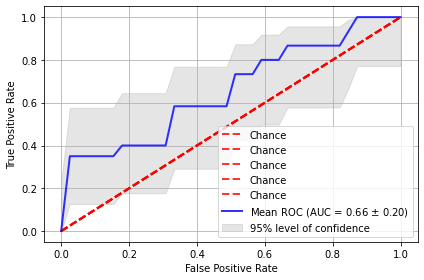

In [26]:
# Sequential Selection with CCA

seed_value= 42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

# fmri_feat={'Ov':X_over_aal,'Pos':X_pos_str_aal,'Neg':X_neg_str_aal}
fmri_feat={'Neg':X_neg_str_aal}
nb_seq_cca_results=pd.DataFrame()
j = 2

tprs = []
aucs = []
auc_est = []
# FPR becomes the independent ordinate
mean_fpr = np.linspace(0, 1, 40)
fig, ax = plt.subplots()

for key,val in fmri_feat.items():
    X_fmri=val
    j+=1

    # Using feature matrices with KNN imputed values 
    X_fmri_imp = knn_feats_fmri[:,(j-1)*166:j*166]
    X_dwi_imp = knn_feats_dwi
    X_eeg_imp = knn_feats_eeg

    X_imputed_combined=np.append(X_fmri_imp,X_dwi_imp,axis=1)
    X_imputed_combined=np.append(X_imputed_combined,X_eeg_imp,axis=1)

    # Varying no. of greedy features
    for i in [8]:
    # for i in range(10):
        f1_scores=[]
        direction='forward'
        # direction='backward'

        for train_idx, test_idx in cv_outer.split(X_over_aal,y):

            X_train = X_imputed_combined[train_idx,:]
            X_test = X_imputed_combined[test_idx,:]
            X_train_f = X_fmri_imp[train_idx,:]
            X_train_d = X_dwi_imp[train_idx,:]
            X_test_f = X_fmri_imp[test_idx,:]
            X_test_d = X_dwi_imp[test_idx,:]
            y_train = y[train_idx]
            y_test = y[test_idx]

            # Sequential feature selector into i+1 features 
            # sfs = SequentialFeatureSelector(clf, direction=direction, scoring='f1', n_features_to_select=i+1)
            clf=None
            clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
            sfs=None
            sfs = SequentialFeatureSelector(clf, direction=direction, scoring='f1', n_features_to_select=i+1)

            sfs.fit(X_train, y_train)
            X_train_seq = sfs.transform(X_train)
            X_test_seq = sfs.transform(X_test)

            # CCA decomposition into 2 components 
            cca=None
            cca = CCA(n_components=2)

            cca.fit(X_train_f, X_train_d)
            X_fmri_cca, X_dwi_cca = cca.transform(X_train_f, X_train_d)
            X_train_cca = np.concatenate((X_fmri_cca, X_dwi_cca), axis=1)
            X_fmri_cca, X_dwi_cca = cca.transform(X_test_f, X_test_d)
            X_test_cca = np.concatenate((X_fmri_cca, X_dwi_cca), axis=1)

            X_train_concat=np.concatenate((X_train_seq, X_train_cca), axis=1)
            X_test_concat=np.concatenate((X_test_seq, X_test_cca), axis=1)

            # SVM Classifier
            # clf = make_pipeline(StandardScaler(), SVC(C=10,gamma=0.01))
            clf.fit(X_train_concat, y_train)
            y_pred = clf.predict(X_test_concat)
            y_prob=clf.predict_proba(X_test_concat)

            fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            
        test_statistic = lambda x: (np.mean(x), np.var(x)) 
        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
                label='Chance', alpha=.8)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)

        # Using Binomial conf intervals, as laid out in Sourati 2015
        [tprs_upper, tprs_lower] = binom_conf_interval(mean_tpr*17, 17, confidence_level=0.95, interval='wilson')  

        upper_lim = auc(mean_fpr, tprs_upper)
        auc_est.append(upper_lim)
        lower_lim = auc(mean_fpr, tprs_lower)
        auc_est.append(lower_lim)
        std_auc = abs(upper_lim-lower_lim)/2

        ax.plot(mean_fpr, mean_tpr, color='b',
                label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                lw=2, alpha=.8)

        ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                        label=r'95% level of confidence')

        ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
        ax.legend(loc="lower right")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.grid('True')    
        plt.tight_layout()   
        plt.savefig('plot/ROC-AUC-SFS-CCA.png')    

        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

        nb_seq_cca_results = nb_seq_cca_results.append({'fMRI':key,'Feats.':i+1,'Direction':direction,'Mean f1':mean(f1_scores),'SEM f1':1.96*stats.sem(f1_scores,ddof=0)},ignore_index=True)

In [25]:
print(y_prob[:,1])

[0.24976049 0.24411366 0.64747726 0.30612331 0.23071782 0.24973733
 0.24973614 0.94150663 0.35502843 0.31716954]


In [27]:
# Forward KNN imputer
print(nb_seq_cca_results)

  fMRI  Feats. Direction   Mean f1  SEM f1
0  Neg     9.0   forward  0.738095     0.0


In [73]:
# GFS with CCA for Clustering Viz

seed_value= 42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

# fmri_feat={'Ov':X_over_aal,'Pos':X_pos_str_aal,'Neg':X_neg_str_aal}
fmri_feat={'Neg':X_neg_str_aal}
nb_seq_cca_results=pd.DataFrame()
j = 0

for key,val in fmri_feat.items():
    X_fmri=val
    j+=1

    # Using feature matrices with KNN imputed values 
    X_fmri_imp = knn_feats_fmri[:,(j-1)*166:j*166]
    X_dwi_imp = knn_feats_dwi
    X_eeg_imp = knn_feats_eeg

    X_imputed_combined=np.append(X_fmri_imp,X_dwi_imp,axis=1)
    X_imputed_combined=np.append(X_imputed_combined,X_eeg_imp,axis=1)

    # Varying no. of greedy features
    for i in [8]:
        f1_scores=[]
        direction='forward'

        # Sequential feature selector into i+1 features 
        clf=None
        clf = make_pipeline(StandardScaler(), SVC(C=10,gamma=0.01))
        sfs=None
        sfs = SequentialFeatureSelector(clf, direction=direction, scoring='f1', n_features_to_select=i+1)
        X_train_seq=sfs.fit_transform(X_imputed_combined, y)

        # CCA decomposition into 2 components 
        cca=None
        cca = CCA(n_components=2)
        X_fmri_cca,X_dwi_cca=cca.fit_transform(X_fmri_imp, X_dwi_imp)
        X_train_cca=np.concatenate((X_fmri_cca, X_dwi_cca), axis=1)

        X_concat_viz=np.concatenate((X_train_seq, X_train_cca), axis=1)

In [51]:
# Forward KNN imputer [selected features]
print(nb_seq_results)

  fMRI  Feats. Direction   Mean f1    SEM f1
0   Ov     9.0   forward  0.803230  0.136343
1  Pos     9.0   forward  0.744469  0.153383
2  Neg     9.0   forward  0.853938  0.045270


In [20]:
# Forward KNN imputer
print(nb_seq_results)

   fMRI  Feats. Direction   Mean f1    SEM f1
0    Ov     1.0   forward  0.600752  0.129122
1    Ov     2.0   forward  0.568371  0.147742
2    Ov     3.0   forward  0.610087  0.136585
3    Ov     4.0   forward  0.713289  0.101534
4    Ov     5.0   forward  0.761911  0.133796
5    Ov     6.0   forward  0.761911  0.133796
6    Ov     7.0   forward  0.761911  0.133796
7    Ov     8.0   forward  0.780079  0.130043
8    Ov     9.0   forward  0.803230  0.136343
9    Ov    10.0   forward  0.803230  0.136343
10  Pos     1.0   forward  0.580398  0.029440
11  Pos     2.0   forward  0.579659  0.083909
12  Pos     3.0   forward  0.731655  0.148166
13  Pos     4.0   forward  0.757607  0.167879
14  Pos     5.0   forward  0.764671  0.162802
15  Pos     6.0   forward  0.744469  0.153383
16  Pos     7.0   forward  0.744469  0.153383
17  Pos     8.0   forward  0.744469  0.153383
18  Pos     9.0   forward  0.744469  0.153383
19  Pos    10.0   forward  0.770794  0.147238
20  Neg     1.0   forward  0.59452

In [67]:
# Forward KNN imputer (gamma=auto)
print(nb_seq_results)

   fMRI  Feats. Direction   Mean f1    SEM f1
0    Ov     1.0   forward  0.619524  0.125334
1    Ov     2.0   forward  0.670000  0.176859
2    Ov     3.0   forward  0.641978  0.179132
3    Ov     4.0   forward  0.650238  0.200825
4    Ov     5.0   forward  0.641818  0.179085
5    Ov     6.0   forward  0.689744  0.192198
6    Ov     7.0   forward  0.689744  0.192198
7    Ov     8.0   forward  0.693077  0.191088
8    Ov     9.0   forward  0.693077  0.191088
9    Ov    10.0   forward  0.693077  0.191088
10  Pos     1.0   forward  0.668904  0.112198
11  Pos     2.0   forward  0.649377  0.156920
12  Pos     3.0   forward  0.661753  0.119140
13  Pos     4.0   forward  0.691136  0.157347
14  Pos     5.0   forward  0.669317  0.150237
15  Pos     6.0   forward  0.672143  0.140267
16  Pos     7.0   forward  0.639562  0.145370
17  Pos     8.0   forward  0.639562  0.145370
18  Pos     9.0   forward  0.652749  0.130462
19  Pos    10.0   forward  0.652749  0.130462
20  Neg     1.0   forward  0.72288

In [49]:
# Forward KNN imputer [Sequential+CCA]
print(nb_seq_cca_results)

   fMRI  Feats. Direction   Mean f1    SEM f1
0    Ov     1.0   forward  0.462724  0.161256
1    Ov     2.0   forward  0.760231  0.131378
2    Ov     3.0   forward  0.710000  0.143614
3    Ov     4.0   forward  0.701457  0.127071
4    Ov     5.0   forward  0.707802  0.169900
5    Ov     6.0   forward  0.605032  0.110506
6    Ov     7.0   forward  0.533397  0.117356
7    Ov     8.0   forward  0.489231  0.135098
8    Ov     9.0   forward  0.437514  0.099017
9    Ov    10.0   forward  0.375356  0.088379
10  Pos     1.0   forward  0.577350  0.101925
11  Pos     2.0   forward  0.730755  0.110790
12  Pos     3.0   forward  0.753246  0.120379
13  Pos     4.0   forward  0.652088  0.064249
14  Pos     5.0   forward  0.565516  0.149148
15  Pos     6.0   forward  0.656406  0.196501
16  Pos     7.0   forward  0.626386  0.195354
17  Pos     8.0   forward  0.567958  0.267757
18  Pos     9.0   forward  0.548333  0.252487
19  Pos    10.0   forward  0.422792  0.151817
20  Neg     1.0   forward  0.58383

In [58]:
# Forward KNN imputer [Sequential+CCA(fixed)]
print(nb_seq_cca_results)

   fMRI  Feats. Direction   Mean f1    SEM f1
0    Ov     1.0   forward  0.534848  0.206017
1    Ov     2.0   forward  0.575801  0.217950
2    Ov     3.0   forward  0.575801  0.217950
3    Ov     4.0   forward  0.583493  0.205085
4    Ov     5.0   forward  0.559697  0.213438
5    Ov     6.0   forward  0.608342  0.208122
6    Ov     7.0   forward  0.579848  0.136372
7    Ov     8.0   forward  0.695943  0.060396
8    Ov     9.0   forward  0.683680  0.079758
9    Ov    10.0   forward  0.660649  0.118134
10  Pos     1.0   forward  0.563333  0.062937
11  Pos     2.0   forward  0.620286  0.088932
12  Pos     3.0   forward  0.595833  0.095071
13  Pos     4.0   forward  0.595833  0.095071
14  Pos     5.0   forward  0.591731  0.092971
15  Pos     6.0   forward  0.591731  0.092971
16  Pos     7.0   forward  0.591731  0.092971
17  Pos     8.0   forward  0.591731  0.092971
18  Pos     9.0   forward  0.591731  0.092971
19  Pos    10.0   forward  0.591731  0.092971
20  Neg     1.0   forward  0.68345

In [18]:
# Backward KNN imputer
print(nb_seq_results)

   fMRI  Feats. Direction   Mean f1    SEM f1
0    Ov     1.0  backward  0.571961  0.082309
1    Ov     2.0  backward  0.576786  0.129850
2    Ov     3.0  backward  0.601238  0.128246
3    Ov     4.0  backward  0.639238  0.109790
4    Ov     5.0  backward  0.623619  0.113072
5    Ov     6.0  backward  0.623619  0.113072
6    Ov     7.0  backward  0.582667  0.103612
7    Ov     8.0  backward  0.607941  0.122586
8    Ov     9.0  backward  0.645216  0.111973
9    Ov    10.0  backward  0.645216  0.111973
10  Pos     1.0  backward  0.556649  0.068646
11  Pos     2.0  backward  0.666911  0.109008
12  Pos     3.0  backward  0.675246  0.107321
13  Pos     4.0  backward  0.651292  0.115232
14  Pos     5.0  backward  0.640744  0.069877
15  Pos     6.0  backward  0.649079  0.069664
16  Pos     7.0  backward  0.658220  0.045277
17  Pos     8.0  backward  0.680198  0.067908
18  Pos     9.0  backward  0.658220  0.045277
19  Pos    10.0  backward  0.674720  0.058642
20  Neg     1.0  backward  0.47401

In [54]:
# Iterative imputer
print(nb_seq_results)

   fMRI  Feats. Direction   Mean f1    SEM f1
0    Ov     1.0   forward  0.508627  0.044172
1    Ov     2.0   forward  0.508627  0.044172
2    Ov     3.0   forward  0.508627  0.044172
3    Ov     4.0   forward  0.508627  0.044172
4    Ov     5.0   forward  0.508627  0.044172
5    Ov     6.0   forward  0.508627  0.044172
6    Ov     7.0   forward  0.508627  0.044172
7    Ov     8.0   forward  0.508627  0.044172
8    Ov     9.0   forward  0.508627  0.044172
9    Ov    10.0   forward  0.587580  0.085342
10  Pos     1.0   forward  0.508627  0.044172
11  Pos     2.0   forward  0.497199  0.043803
12  Pos     3.0   forward  0.519763  0.068821
13  Pos     4.0   forward  0.519763  0.068821
14  Pos     5.0   forward  0.519763  0.068821
15  Pos     6.0   forward  0.519763  0.068821
16  Pos     7.0   forward  0.519763  0.068821
17  Pos     8.0   forward  0.519763  0.068821
18  Pos     9.0   forward  0.519763  0.068821
19  Pos    10.0   forward  0.519763  0.068821
20  Neg     1.0   forward  0.50862

In [160]:
# t-SNE (2D)

seed_value= 42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

# --- No. indicated #subs ---
k = 48
tsne = TSNE(n_components=2, verbose=0, perplexity=10, n_iter=300)
# X=X_imputed_combined
X=X_concat_viz

# tsne_results = tsne.fit_transform(X_seq_tsne[97:])
tsne_results = tsne.fit_transform(X)

fig, ax = plt.subplots()
# ax = plt.figure(figsize=(10,8))
cm = plt.cm.viridis
scat = ax.scatter(
    x=tsne_results[:,0], 
    y=tsne_results[:,1], 
    c=y,
    cmap=cm)
legend_elem = [Line2D([0], [0], marker='o', color=cm(0.),lw=0,label='No Seizure'),
                   Line2D([0], [0], marker='o', color=cm(1.),lw=0,label='Late Seizure')]

legend1 = ax.legend(handles=legend_elem,
                    loc="upper right")

# ax.add_artist(legend1)
# ax.set(title="t-SNE plot: [%2.0f features, %1.0f axes]" % (63,2))
ax.set_xlabel('Component-1')
ax.set_ylabel('Component-2')

# handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
# legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")
plt.tight_layout()     
# plt.savefig('plot/X-imputed-t-SNE-2D.png')       
plt.savefig('plot/SFS-CCA-t-SNE-2D.png')     

/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 48 samples in 0.000s...
[t-SNE] Computed neighbors for 48 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 48 / 48
[t-SNE] Mean sigma: 500.773260
[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.850014
[t-SNE] KL divergence after 300 iterations: 4.137100


/home/navid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  app.launch_new_instance()


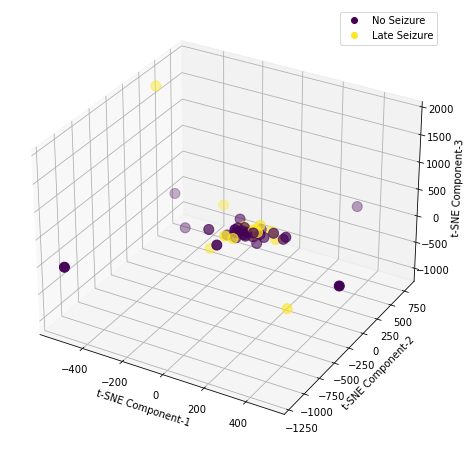

In [167]:
# t-SNE (3D)

seed_value= 42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

# --- No. indicated #subs ---
k = 48
X=X_imputed_combined
# X=X_concat_viz

tsne = TSNE(n_components=3, verbose=1, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(X)

ax = plt.figure(figsize=(8,8)).gca(projection='3d')
cm = plt.cm.viridis
scat = ax.scatter(
    xs=tsne_results[:,0], 
    ys=tsne_results[:,1], 
    zs=tsne_results[:,2], 
    c=y,
    s=100,
    cmap=cm)
legend_elem = [Line2D([0], [0], marker='o', color=cm(0.),lw=0,label='No Seizure'),
                   Line2D([0], [0], marker='o', color=cm(1.),lw=0,label='Late Seizure')]

legend1 = ax.legend(handles=legend_elem,
                    loc="upper right")

ax.set_xlabel('t-SNE Component-1')
ax.set_ylabel('t-SNE Component-2')
ax.set_zlabel('t-SNE Component-3')

# handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
# legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")
# plt.tight_layout()   
plt.savefig('plot/t-SNE-3D-X-imputed.png')   
# plt.savefig('plot/t-SNE-3D-X-SFS-CCA.png')   

In [158]:
# PCA (2D) & k-means
seed_value= 42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

from sklearn.decomposition import PCA
n_clusters=2
colors = ["#4EACC5","#FF9C34"]
cm = plt.cm.viridis

data=X_concat_viz
# data=X_imputed_combined

k_means = KMeans(init="k-means++",n_clusters=n_clusters,n_init=10,random_state=42)
X = PCA(n_components=3).fit_transform(data)
k_means.fit(X)
k_means_cluster_centers = k_means.cluster_centers_
k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)

fig = plt.figure()
# fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
ax = plt.figure(figsize=(8,8)).gca(projection='3d')
for k in range(n_clusters):
# for k, col in zip(range(n_clusters), colors):
    my_members = (k_means_labels==k)
    labels=(y==k)
    print(labels)
    # cluster_center = k_means_cluster_centers[k]
    # ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker="o",markersize=10)
    # ax.plot(X[labels, 0], X[labels, 1], "w", marker="o",markersize=10)
    # ax.plot(
    #     cluster_center[0],
    #     cluster_center[1],
    #     "o",
    #     markerfacecolor=col,
    #     markeredgecolor="k",
    #     markersize=10,
    # )
    ax.scatter(
    xs=X[labels, 0], 
    ys=X[labels, 1], 
    zs=X[labels, 2], 
    s=100,
    # markersize=10,
    # c=k,
    cmap=cm)

# ax.set_title("KMeans")
# ax.set_xticks(())
# ax.set_yticks(())
ax.set_xlabel('Principal component-1')
ax.set_ylabel('Principal component-2')
ax.set_ylabel('Principal component-3')
plt.tight_layout()  
 
# plt.savefig('plot/k-means-X-SFS-CCA.png')    
# plt.savefig('plot/k-means-X-imputed.png')   
# plt.savefig('plot/PCA-X-SFS-CCA.png')     
# plt.savefig('plot/PCA-3D-X-imputed.png')   
plt.savefig('plot/PCA-3D-X-SFS-CCA.png')   

/home/navid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


[ True  True  True  True  True  True False False  True  True  True False
 False  True False False  True False  True  True  True False False False
 False  True  True  True False  True False False  True False False  True
  True False  True  True  True  True  True  True  True  True  True  True]
[False False False False False False  True  True False False False  True
  True False  True  True False  True False False False  True  True  True
  True False False False  True False  True  True False  True  True False
 False  True False False False False False False False False False False]


<Figure size 432x288 with 0 Axes>

In [199]:
# PCA (3D) & k-means
seed_value= 42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

from sklearn.decomposition import PCA
# %matplotlib notebook

# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import axes3d  

n_clusters=2
colors = ["#4EACC5","#FF9C34"]
cm = plt.cm.viridis

data=X_concat_viz
# data=X_imputed_combined

X = PCA(n_components=3).fit_transform(data)

ax = plt.figure(figsize=(8,8)).gca(projection='3d')
for k in range(n_clusters):
    my_members = (k_means_labels==k)
    labels=(y==k)
    ax.scatter(
    xs=X[labels, 0], 
    ys=X[labels, 1], 
    zs=X[labels, 2], 
    s=100,
    cmap=cm)

ax.set_xlabel('Principal component-1')
ax.set_ylabel('Principal component-2')
ax.set_ylabel('Principal component-3')
ax.view_init(60, 30)
plt.show()
 
# plt.savefig('plot/PCA-3D-X-SFS-CCA.png')   
# plt.savefig('plot/PCA-3D-X-imputed.png')   

/home/navid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0]


/home/navid/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


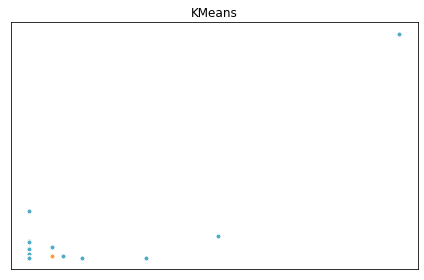

In [101]:
# Spectral Clustering
seed_value= 42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

from sklearn.cluster import SpectralClustering
n_clusters=2
colors = ["#4EACC5","#FF9C34"]
X=X_imputed_combined
# X=X_concat_viz

clustering = SpectralClustering(n_clusters=n_clusters,
        assign_labels='kmeans',
        random_state=42).fit(X)
# k_means_cluster_centers = clustering.cluster_centers_
# k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
k_means_labels=clustering.labels_
print(k_means_labels)

fig = plt.figure()
# fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
ax = fig.add_subplot(1, 1, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    # cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".",markersize=10)
    # ax.plot(
    #     cluster_center[0],
    #     cluster_center[1],
    #     "o",
    #     markerfacecolor=col,
    #     markeredgecolor="k",
    #     markersize=10,
    # )
ax.set_title("KMeans")
ax.set_xticks(())
ax.set_yticks(())
# plt.text(-3.5, 1.8, "train time: %.2fs\ninertia: %f" % (t_batch, k_means.inertia_))
# plt.grid('True')    
plt.tight_layout()  
# plt.show()
 
plt.savefig('plot/SFS-CCA-spectral-k-means.png')    

In [98]:
from sklearn.datasets import make_blobs

np.random.seed(0)

batch_size = 5
centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
Q, labels_true = make_blobs(n_samples=50, centers=centers, cluster_std=0.7)

# MMINet SMIG Feature Reduction

In [70]:
# MMINet SMIG with all

seed_value= 42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

fmri_feat={'Ov':X_over_aal,'Pos':X_pos_str_aal,'Neg':X_neg_str_aal}
nb_smig_results=pd.DataFrame()
j = 0

for key,val in fmri_feat.items():
    X_fmri=val
    j+=1

    # # Using feature matrices with KNN imputed values 
    X_fmri_imp = knn_feats_fmri[:,(j-1)*166:j*166]
    X_dwi_imp = knn_feats_dwi
    X_eeg_imp = knn_feats_eeg

    X_imputed_combined=np.append(X_fmri_imp,X_dwi_imp,axis=1)
    X_imputed_combined=np.append(X_imputed_combined,X_eeg_imp,axis=1)

    # Varying no. of projected dimensions
    # for i in [2]:
    for i in range(10):
        f1_scores=[]

        for train_idx, test_idx in cv_outer.split(X_over_aal,y):

            X_train = X_imputed_combined[train_idx,:]
            X_test = X_imputed_combined[test_idx,:]
            y_train = y[train_idx]
            y_test = y[test_idx]

            # Project n-dimensional input features into i+1 dimensions
            model=None
            model=MMINet(input_dim=232, output_dim=i+1, net='nonlinear')

            model.learn(X_train, y_train, num_epochs=30)
            z_train = model.reduce(X_train)
            z_test = model.reduce(X_test)

            # SVM Classifier
            # clf = make_pipeline(StandardScaler(), SVC(C=10,gamma=0.01))
            clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
            clf.fit(z_train, y_train)
            y_pred = clf.predict(z_test)

            f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

        nb_smig_results = nb_smig_results.append({'fMRI':key,'Feats.':i+1,'Mean f1':mean(f1_scores),'SEM f1':1.96*stats.sem(f1_scores,ddof=0)},ignore_index=True)

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
E

In [60]:
# MMINet SMIG with CCA

seed_value= 42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

fmri_feat={'Ov':X_over_aal,'Pos':X_pos_str_aal,'Neg':X_neg_str_aal}
nb_smig_cca_results=pd.DataFrame()
j = 0

for key,val in fmri_feat.items():
    X_fmri=val
    j+=1

    # # Using feature matrices with KNN imputed values 
    X_fmri_imp = knn_feats_fmri[:,(j-1)*166:j*166]
    X_dwi_imp = knn_feats_dwi
    X_eeg_imp = knn_feats_eeg

    X_imputed_combined=np.append(X_fmri_imp,X_dwi_imp,axis=1)
    X_imputed_combined=np.append(X_imputed_combined,X_eeg_imp,axis=1)

    # Varying no. of projected dimensions
    # for i in [2]:
    for i in range(10):
        f1_scores=[]

        for train_idx, test_idx in cv_outer.split(X_over_aal,y):

            X_train = X_imputed_combined[train_idx,:]
            X_test = X_imputed_combined[test_idx,:]
            y_train = y[train_idx]
            y_test = y[test_idx]

            X_train_f = X_fmri_imp[train_idx,:]
            X_train_d = X_dwi_imp[train_idx,:]
            X_test_f = X_fmri_imp[test_idx,:]
            X_test_d = X_dwi_imp[test_idx,:]

            # Project n-dimensional input features into i+1 dimensions
            model=None
            model=MMINet(input_dim=232, output_dim=6, net='linear')

            model.learn(X_train, y_train, num_epochs=10)
            z_train = model.reduce(X_train)
            z_test = model.reduce(X_test)

            # CCA decomposition into i+1 components 
            cca=None
            cca = CCA(n_components=i+1)

            cca.fit(X_train_f, X_train_d)
            X_fmri_cca, X_dwi_cca = cca.transform(X_train_f, X_train_d)
            X_train_cca = np.concatenate((X_fmri_cca, X_dwi_cca), axis=1)
            X_fmri_cca, X_dwi_cca = cca.transform(X_test_f, X_test_d)
            X_test_cca = np.concatenate((X_fmri_cca, X_dwi_cca), axis=1)

            X_train_concat=np.concatenate((z_train, X_train_cca), axis=1)
            X_test_concat=np.concatenate((z_test, X_test_cca), axis=1)

            # SVM Classifier
            clf=None
            clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
            clf.fit(X_train_concat, y_train)
            y_pred = clf.predict(X_test_concat)

            f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

        nb_smig_cca_results = nb_smig_cca_results.append({'fMRI':key,'Feats.':i+1,'Mean f1':mean(f1_scores),'SEM f1':1.96*stats.sem(f1_scores,ddof=0)},ignore_index=True)

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
E

In [61]:
print(nb_smig_results)

   fMRI  Feats.   Mean f1    SEM f1
0    Ov     1.0  0.768220  0.069548
1    Ov     2.0  0.795738  0.072854
2    Ov     3.0  0.824635  0.075357
3    Ov     4.0  0.573993  0.147975
4    Ov     5.0  0.647029  0.134250
5    Ov     6.0  0.618516  0.128758
6    Ov     7.0  0.722088  0.130511
7    Ov     8.0  0.738579  0.076569
8    Ov     9.0  0.673250  0.143623
9    Ov    10.0  0.662143  0.125717
10  Pos     1.0  0.508627  0.044172
11  Pos     2.0  0.478333  0.062597
12  Pos     3.0  0.584627  0.041966
13  Pos     4.0  0.567333  0.072338
14  Pos     5.0  0.529333  0.073671
15  Pos     6.0  0.551333  0.057004
16  Pos     7.0  0.515597  0.038374
17  Pos     8.0  0.533333  0.130993
18  Pos     9.0  0.630850  0.084931
19  Pos    10.0  0.616469  0.062846
20  Neg     1.0  0.498333  0.034694
21  Neg     2.0  0.488627  0.070585
22  Neg     3.0  0.478333  0.062597
23  Neg     4.0  0.488627  0.070585
24  Neg     5.0  0.474012  0.093553
25  Neg     6.0  0.515597  0.038374
26  Neg     7.0  0.546627  0

In [47]:
# KNN imputer (Gamma 'auto')
print(nb_smig_results)

   fMRI  Feats.   Mean f1    SEM f1
0    Ov     1.0  0.640183  0.150830
1    Ov     2.0  0.652601  0.138972
2    Ov     3.0  0.667546  0.101421
3    Ov     4.0  0.741941  0.126607
4    Ov     5.0  0.671086  0.139078
5    Ov     6.0  0.776397  0.058793
6    Ov     7.0  0.554286  0.094460
7    Ov     8.0  0.650476  0.137770
8    Ov     9.0  0.566630  0.105765
9    Ov    10.0  0.570446  0.105505
10  Pos     1.0  0.565556  0.107636
11  Pos     2.0  0.646271  0.110059
12  Pos     3.0  0.600786  0.114375
13  Pos     4.0  0.582088  0.124094
14  Pos     5.0  0.553311  0.106755
15  Pos     6.0  0.531897  0.107200
16  Pos     7.0  0.546794  0.138137
17  Pos     8.0  0.599968  0.102269
18  Pos     9.0  0.618080  0.093387
19  Pos    10.0  0.603897  0.035277
20  Neg     1.0  0.646286  0.058673
21  Neg     2.0  0.529580  0.113797
22  Neg     3.0  0.633889  0.121589
23  Neg     4.0  0.675365  0.124838
24  Neg     5.0  0.694723  0.065800
25  Neg     6.0  0.576989  0.098653
26  Neg     7.0  0.553311  0

In [71]:
# KNN imputer (Non-linear, Gamma 'auto')
print(nb_smig_results)

   fMRI  Feats.   Mean f1    SEM f1
0    Ov     1.0  0.615770  0.109528
1    Ov     2.0  0.537712  0.027893
2    Ov     3.0  0.508627  0.044172
3    Ov     4.0  0.597968  0.135767
4    Ov     5.0  0.587580  0.085342
5    Ov     6.0  0.553331  0.045917
6    Ov     7.0  0.595516  0.096501
7    Ov     8.0  0.478333  0.040168
8    Ov     9.0  0.605476  0.113770
9    Ov    10.0  0.516667  0.054662
10  Pos     1.0  0.587580  0.085342
11  Pos     2.0  0.594722  0.128416
12  Pos     3.0  0.587580  0.085342
13  Pos     4.0  0.583833  0.094478
14  Pos     5.0  0.613413  0.121469
15  Pos     6.0  0.612286  0.139620
16  Pos     7.0  0.564524  0.098754
17  Pos     8.0  0.600603  0.101010
18  Pos     9.0  0.554818  0.120491
19  Pos    10.0  0.476630  0.061686
20  Neg     1.0  0.598469  0.121594
21  Neg     2.0  0.498627  0.056209
22  Neg     3.0  0.661707  0.089311
23  Neg     4.0  0.616222  0.100120
24  Neg     5.0  0.564220  0.100913
25  Neg     6.0  0.590803  0.087419
26  Neg     7.0  0.567333  0

In [69]:
# KNN imputer (Gamma & C set)
print(nb_smig_results)

   fMRI  Feats.   Mean f1    SEM f1
0    Ov     1.0  0.553333  0.112934
1    Ov     2.0  0.578371  0.139814
2    Ov     3.0  0.638920  0.139712
3    Ov     4.0  0.699429  0.059520
4    Ov     5.0  0.583077  0.140008
5    Ov     6.0  0.703952  0.091502
6    Ov     7.0  0.585238  0.123683
7    Ov     8.0  0.698476  0.087101
8    Ov     9.0  0.573714  0.036110
9    Ov    10.0  0.612143  0.129209
10  Pos     1.0  0.508627  0.044172
11  Pos     2.0  0.508627  0.044172
12  Pos     3.0  0.519333  0.083389
13  Pos     4.0  0.535905  0.103515
14  Pos     5.0  0.515311  0.103790
15  Pos     6.0  0.509333  0.095367
16  Pos     7.0  0.497905  0.095262
17  Pos     8.0  0.551778  0.100166
18  Pos     9.0  0.503770  0.086782
19  Pos    10.0  0.563833  0.119451
20  Neg     1.0  0.508627  0.044172
21  Neg     2.0  0.488627  0.070585
22  Neg     3.0  0.529333  0.073671
23  Neg     4.0  0.529333  0.073671
24  Neg     5.0  0.584627  0.041966
25  Neg     6.0  0.509333  0.095367
26  Neg     7.0  0.531333  0

In [42]:
# Iterative imputer
print(nb_smig_results)

   fMRI  Feats.   Mean f1    SEM f1
0    Ov     1.0  0.577286  0.088231
1    Ov     2.0  0.537582  0.092772
2    Ov     3.0  0.496630  0.033806
3    Ov     4.0  0.478333  0.040168
4    Ov     5.0  0.496630  0.033806
5    Ov     6.0  0.498333  0.034694
6    Ov     7.0  0.554286  0.094460
7    Ov     8.0  0.478333  0.040168
8    Ov     9.0  0.496630  0.033806
9    Ov    10.0  0.478333  0.040168
10  Pos     1.0  0.508627  0.044172
11  Pos     2.0  0.508627  0.044172
12  Pos     3.0  0.508627  0.044172
13  Pos     4.0  0.508627  0.044172
14  Pos     5.0  0.508627  0.044172
15  Pos     6.0  0.508627  0.044172
16  Pos     7.0  0.508627  0.044172
17  Pos     8.0  0.496630  0.033806
18  Pos     9.0  0.586786  0.120216
19  Pos    10.0  0.553333  0.112934
20  Neg     1.0  0.508627  0.044172
21  Neg     2.0  0.508627  0.044172
22  Neg     3.0  0.508627  0.044172
23  Neg     4.0  0.508627  0.044172
24  Neg     5.0  0.546627  0.054458
25  Neg     6.0  0.508627  0.044172
26  Neg     7.0  0.545833  0

In [61]:
# KNN imputer
print(nb_smig_cca_results)

   fMRI  Feats.   Mean f1    SEM f1
0    Ov     1.0  0.728445  0.121299
1    Ov     2.0  0.510160  0.186742
2    Ov     3.0  0.577515  0.081782
3    Ov     4.0  0.599333  0.109330
4    Ov     5.0  0.563333  0.108304
5    Ov     6.0  0.532866  0.110397
6    Ov     7.0  0.464342  0.109400
7    Ov     8.0  0.452913  0.105632
8    Ov     9.0  0.454048  0.102568
9    Ov    10.0  0.501548  0.150443
10  Pos     1.0  0.598338  0.101557
11  Pos     2.0  0.682424  0.075846
12  Pos     3.0  0.441850  0.070921
13  Pos     4.0  0.391008  0.143949
14  Pos     5.0  0.423343  0.121364
15  Pos     6.0  0.546627  0.054458
16  Pos     7.0  0.382217  0.152161
17  Pos     8.0  0.455551  0.124060
18  Pos     9.0  0.435294  0.125278
19  Pos    10.0  0.607167  0.076163
20  Neg     1.0  0.537582  0.092772
21  Neg     2.0  0.631094  0.087881
22  Neg     3.0  0.426203  0.140361
23  Neg     4.0  0.449592  0.047439
24  Neg     5.0  0.347692  0.142391
25  Neg     6.0  0.435294  0.125278
26  Neg     7.0  0.435294  0

In [36]:
print(nb_results.to_latex(index=False))  

\begin{tabular}{}
\toprule
Empty DataFrame
Columns: Index([], dtype='object')
Index: Index([], dtype='object') \\
\bottomrule
\end{tabular}



In [11]:
# Subspace Clustering

# model_sub = ElasticNetSubspaceClustering(n_clusters=2,algorithm='lasso_lars',gamma=50).fit(X_seq_tsne[97:])
model_sub = ElasticNetSubspaceClustering(n_clusters=2,algorithm='lasso_lars',gamma=50).fit(knn_features_df)

# model = SparseSubspaceClusteringOMP(n_clusters=3).fit(X_sub.T)
print(model_sub.labels_)

  0% (0 of 48) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  2% (1 of 48) |                         | Elapsed Time: 0:00:00 ETA:  00:00:00
 14% (7 of 48) |###                      | Elapsed Time: 0:00:00 ETA:   0:00:00
 29% (14 of 48) |#######                 | Elapsed Time: 0:00:00 ETA:   0:00:00
 35% (17 of 48) |########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 50% (24 of 48) |############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 68% (33 of 48) |################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 77% (37 of 48) |##################      | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (41 of 48) |####################    | Elapsed Time: 0:00:00 ETA:   0:00:00
 89% (43 of 48) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (48 of 48) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


[1 1 1 1 1 1 0 0 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0
 0 1 1 1 1 1 1 1 1 1 1]


In [102]:
# Subspace Clustering

X=X_concat_viz
# model_sub = ElasticNetSubspaceClustering(n_clusters=2,algorithm='lasso_lars',gamma=50).fit(X_seq_tsne[97:])
model_sub = ElasticNetSubspaceClustering(n_clusters=2,algorithm='lasso_lars',gamma=50).fit(X)

# model = SparseSubspaceClusteringOMP(n_clusters=3).fit(X_sub.T)
print(model_sub.labels_)

  0% (0 of 48) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 75% (36 of 48) |##################      | Elapsed Time: 0:00:00 ETA:  00:00:00
100% (48 of 48) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


[0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 0 1 0 0 1
 1 0 0 0 0 0 1 0 0 0 0]


In [104]:
# Imputed Features
from sklearn.metrics import accuracy_score
y_inv=1-y
# accuracy_score(y_inv, model_sub.labels_)
accuracy_score(y, model_sub.labels_)

0.875

In [60]:
# from metrics.cluster.accuracy import clustering_accuracy
from sklearn.metrics import accuracy_score
# acc = clustering_accuracy(y, model_sub.labels_)
accuracy_score(y, model_sub.labels_)

0.4791666666666667

In [27]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
# enc.fit(y)
y_new=y.reshape(len(y), 1)
q=enc.fit_transform(y_new)

# Current Progress (6/10, SFR):

There are currently three multimodal classifiers up and running. One which uses the conditional independence assumption (or naive bayes approach) to deal with missing values and two which use imputers to deal with missing values. So far, none of the multimodal classifiers outperform the single modality classifiers and only the feature union (just lump them all together) and hard label voting classifier perform at the same level. 

There might be some things that are dependent on implementation or that require hyper parameter tuning as I've noted through the notebook. We may also see some improvements as we get more subjects. 